## Notes

*Note: This paper goes through A3C, later when I do the implementation I'll make some tweaks to make it A2C as that's what's more used apparently*

### High Level Quick Read Through

What problem is this paper solving? We saw in the DQN paper that one of their innovations was the experience replay. This allowed us to store many transitions and randomly sample, breaking the temporal data correlations and stabalizing training. However in this paper the authors point out several drawbacks to the experience replay:

1. It's memory intensive
2. It's computationally heavy, each transition is replayed multiple times
3. it's off-policy only. You can't apply it to other methods that learn from the current policy.

They proposed a new way to stabalize the training that replaces the experience replay with asynchronicity. They have a new setup where there's one global network that we want to train. We then launch multiple threads that each have a copy of the network parameters and their own seperate copy of the environment. Each of these workers does a small number of steps and collect experiences from those different networks. They then all compute the gradients of the loss and then push those to the global network.

In A3C the workers don't wait for each other and once they calculate the gradients they push them to the global network. None of them have a lock on the global parameters. This works because the experiences of the different agents are not super correlated with each other. This has a stabalizing effect. They apply this framework to four different RL algorithms, but the one I'll focus on is the application to Advantage Actor-Critic.

Some things I'm thinking about:
Do each of the workers in the environment initialize to the same state? or do they randomly start from different parts of the environment? what if there's not many choices at the start and they all do the same thing? when each of them explores are they doing random things or what's the way the decide there?

The actor network outputs a probability distribution which the agent samples from. They also add an entropy bonus (kind of like a temperature) that smooths out the distribution. So they explore different areas.

In A2C workers wait for each other?

They wait for each other. They all go into their environments and collect some data and then wait. Then it updates all of them in one batch. This can leverage GPUs better.

##### Quick dive into Actor-Critic and Advantage Function

First off DQN is not an actor-critic algorithm. It's a purely value-based algorithm, the policy is implicitly derived from the Q-values predicted for each action in a state. The policy is to pick whichever action has the highest Q value. There's no network that outputs actions or anything that represents the policy. Note: one small drawback of these value based methods is that they're not good for continuous actions (e.g. how hard should I do action x).

In actor critic we have an actor and the critic. The actor has a policy and it's job is to take an action based on the policy. The critic's job is to learn a value function that predicts how good a state is. The learning loop is as follows:

1. The actor takes an action based on its policy.
2. The actor then gets a reward and a new state.
3. The critic then calculates how surprising that outcome was. The critic has an expectation of the state at t=0, the outcome at t+1 that we compare it to is the reward plus the value of the new state we're in (kinda similar to DQN). We calculate the TD error (this is the surprise), we look at the difference between the reward plus the value function at the new state and the value that the critic predicted from the t=0. The TD error is an estimate of *advantage*. It tells the actor how much better or worse the action was than expected.
4. Then there's the learning, both the actor and the critic learn. The actor adjusts it's weights. If the TD error was positive (the policy did better than the critic expected) then it adjusts its policy to make that action more likely. And the inverse if the TD error is negative. The critic also learns. They adjust the value function to be closer to the observed reality.

Why is this better though? It's better because we learn a policy directly while also using a value function to make the learning process more stable and efficient. This has a few advantages. 

The first is that we get an explicit stochastic policy. There are a few reasons this is good. The first is that it naturally helps to solve the exploration-exploitation problem by giving us a distribution to sample from. The second is that it helps to solve partial observability. In a partially observable world two or more different world states can look identical to the agent. In those two world states two different seperate actions could each be optimal for each. For a deterministic policy it will be unstable and prefer both actions equally, it's not perfect but it's stable and robust. The last is that optimal policies are sometimes inherently stochastic (think about how you have to sometimes play that bad hand in poker lol).

The second is that it can handle continuous actions. Say for example steering a car. In DQN you might need to discretize the steering wheel angle into maybe slots of every 10 degrees. In A3C you can output a continuous probability distribution. So for the steering wheel you could have two output neurons, one that represents the mean of the distribution and one that outputs the standard deviation for the distribution. For example mean angle = 30degrees with an STD of 5. Then we sample from it and apply it to the sterring wheel. Note if we have some combo of things to control some discrete and continuous we'd just have different output heads for each component of the action. This is set up such that we might have one big shared main network that outputs a vector (maybe somehow representing the world state) that feeds into a seperate network for each of the different possible actions. We backprop through all and sum the gradients.

Aside: What if the optimal action is a distribution but one that's not gaussian however? A bit advanced but we can output other values to make up for this, for example mixture of gaussians or skewed distribution.

How is the actor's policy updated? // for more gaussian output actions

If we see a positive advantage (the action was better than expected) then we want to update our parameters to make that action more likely in the future. This is different to supervised learning where we have a ground truth label or where the loss is based on a difference that we calculate.

The "loss function" or objective function we're maximizing is not based on an action error. It's based on the log-probability of the action we took, scaled in magnitude and direction by how good the outcome was (the advantage). For this we need to look at the policy gradient.

defined by *latex here*

Translated to english this formula says that the policy gradient is the gradient (with respect to the parameters theta) of the log probability of taking action a in state s under the policy pi multiplied by the advantage. Inside the log(pi(a|s)) term we get the formula for the probability density for a gaussian which is:

defined by *latex here*

For context this is what that graph looks like:

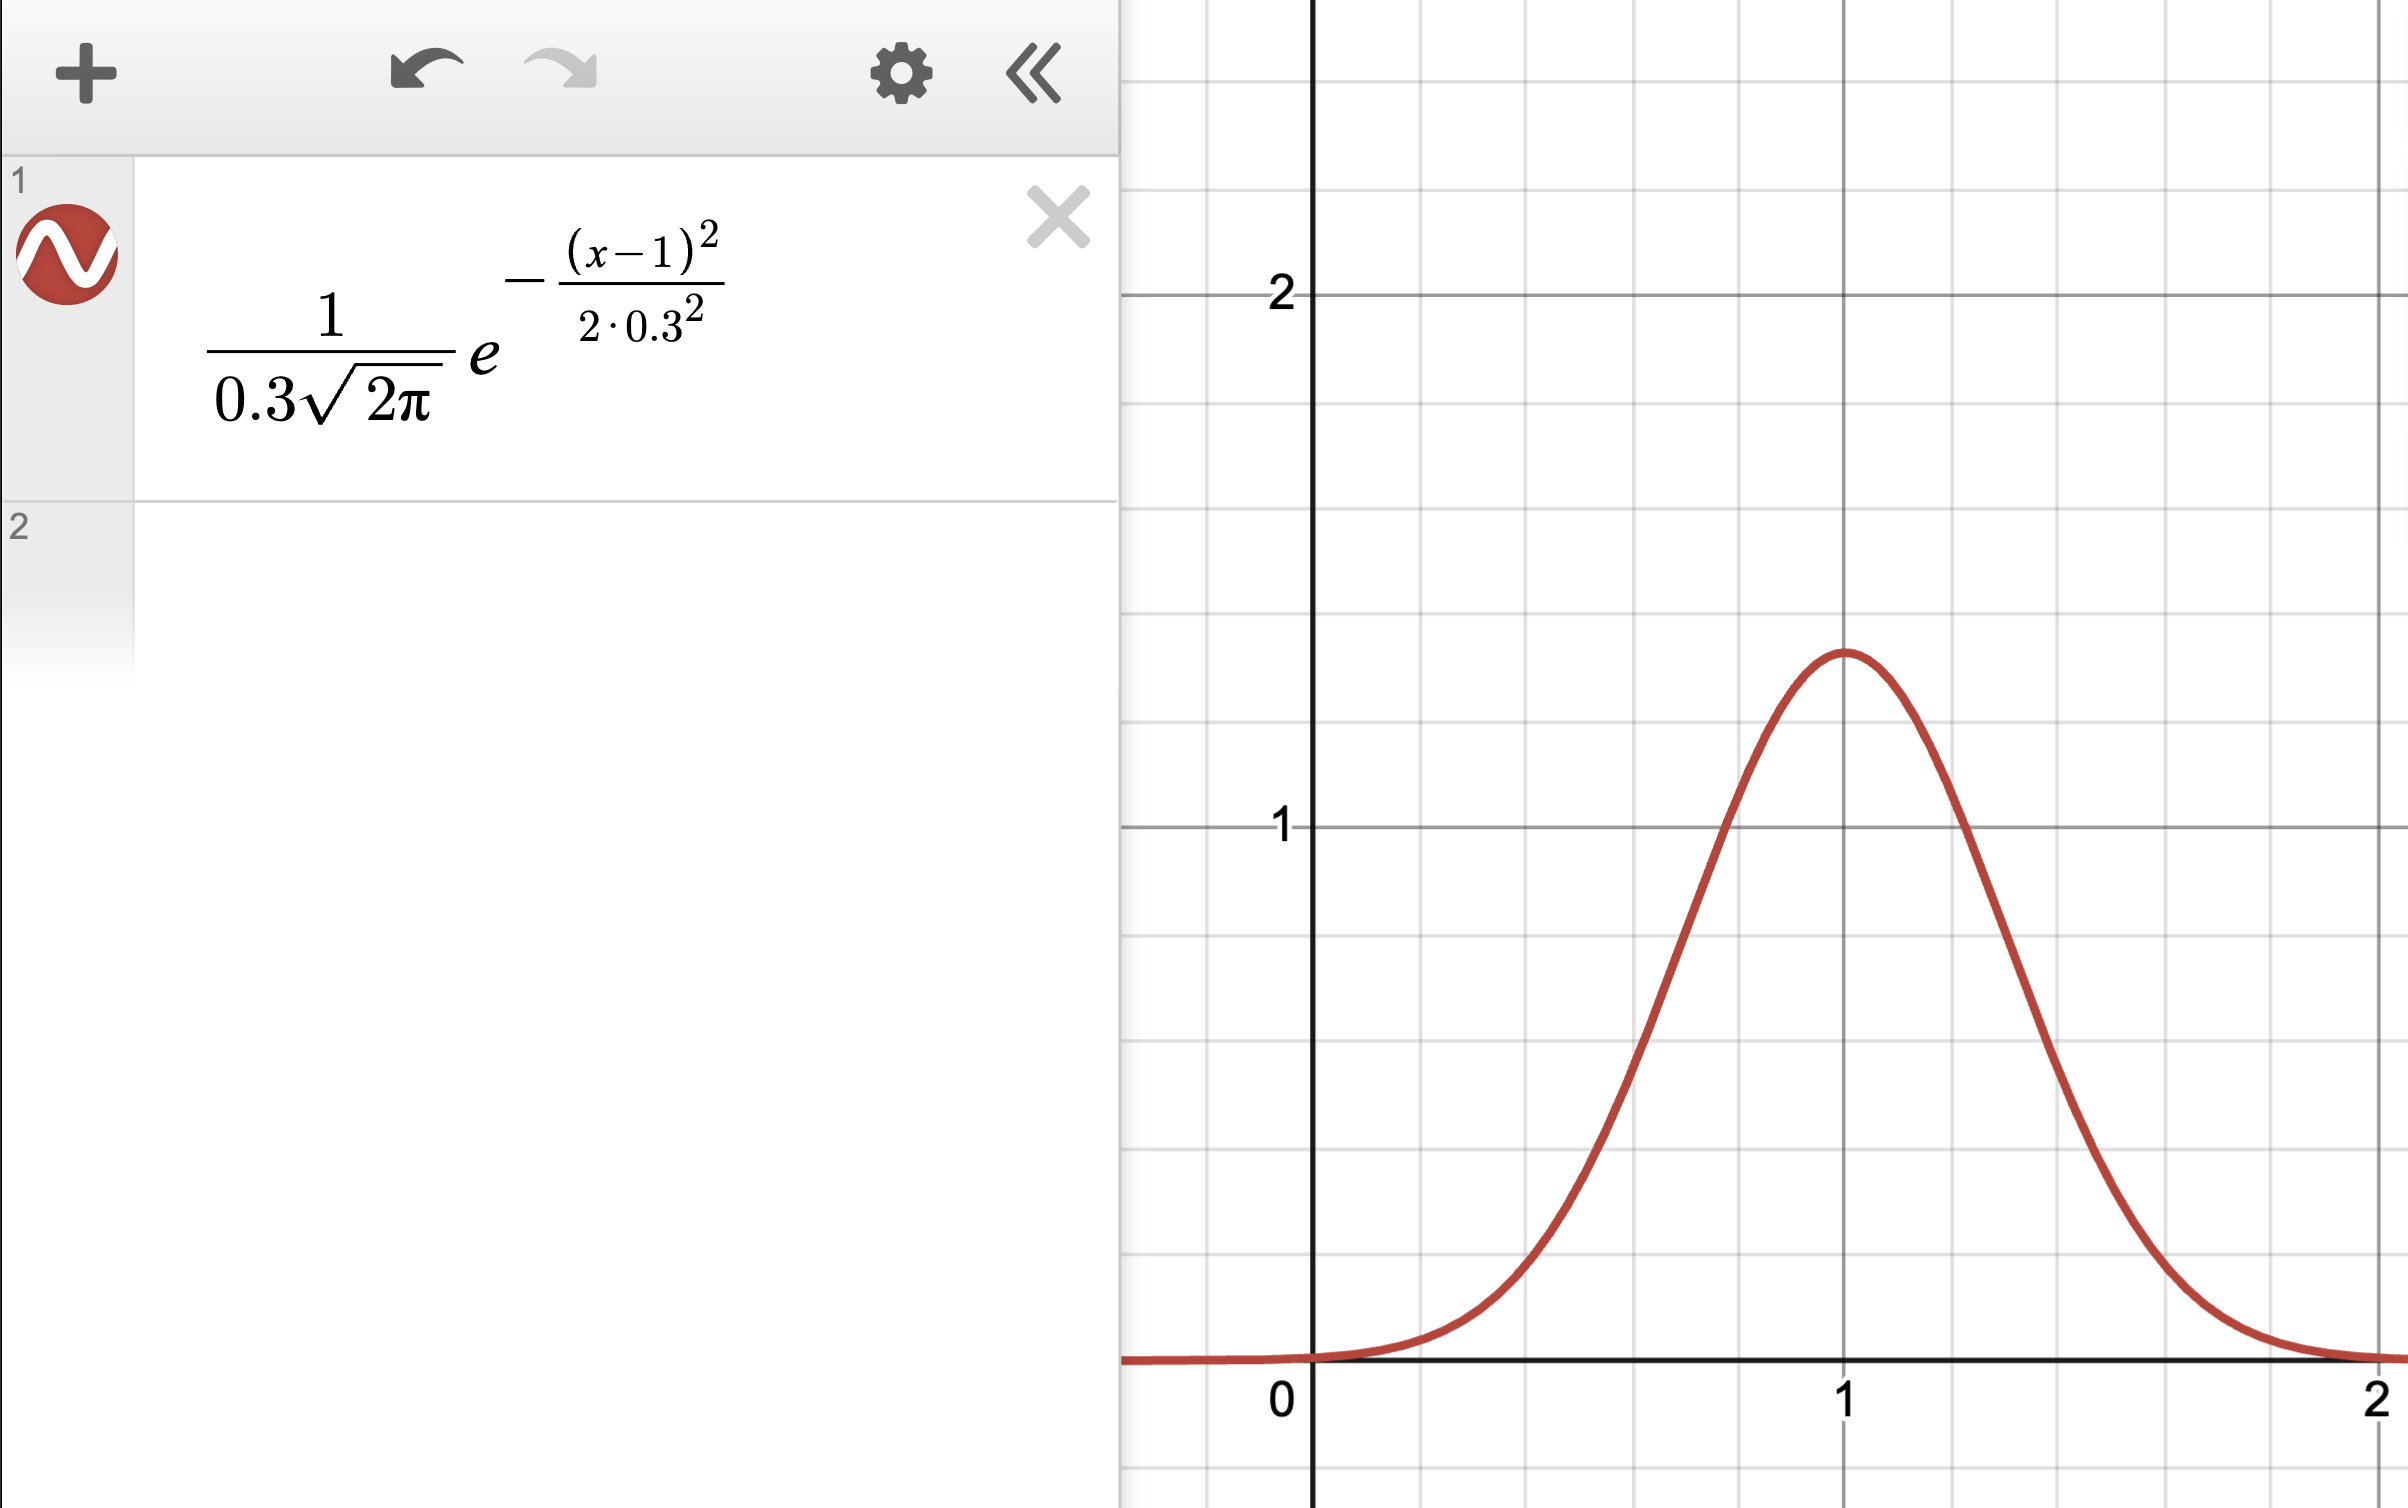

This is kind of scary looking but if we take the natural log of it it simplifies down to this

defined by *latex here*

From here we calculate the partial derivatives with respect to either the mean or the standard deviation. If the advantage is positive then the optimizer will adjust the network to move the mean in whichever direction the action is. But what happens if we take the partial derivative with respect to the standard deviation? If we calculate it out we get this

defined by *latex here*

Note: If a gradient is positive the parameter value will decrease, if it's negative the parameter value will increase.

The gradient is interesting because it has two parts to it. It has the 1/STD and the other term. That first term will always be positive. If a good action is close to the mean then the second term will be small making the expression positive. This will serve to decrease the STD. If the good action was far from the mean then the second term will be large making it negative, therefore the optimizer will increase the std.

So overall the mean is nudged towards and away from the action that was taken depending on the advantage. The STD is also modulated by similar things but it depends on how far away the action was from the current mean.

Now, how is the critic network setup? The critic is actually pretty coupled with the actor network. Similarly to how each seperate action might have it's own head after going through the main body of the main network and getting what might be considered the vector representing the world state, the critic network also gets it's own head. It, however, just outputs a single value V(s) representing the value. The value head is trying to predict the total cumulative discounted future reward, or the return. The critic's setup is a bit easier and here we just calculate the MSE loss compared to what the next state's reward + value is.

<blockquote>
    An aside on the gradients of a few different action types and how they flow backwards:
    Earlied we looked quickly at the gaussian actions which are cool. However there could be many types of actions.
    
    1. Discrete / Categorical Actions

    
    


</blockquote>

Sidenote: why does the actor critic setup make the learning more stable?


N step returns

Loss functions

Entropy regularization

Full algorithm walkthrough

I want a high level intuitive understanding on how this learns and explores and gets good

### Introduction



Questions while reading:

Do each of the workers in the environment initialize to the same state? or do they randomly start from different parts of the environment? what if there's not many choices at the start and they all do the same thing? when each of them explores are they doing random things or what's the way the decide there?

In A2C workers wait for each other?

Why actually does the actor critic setup make the learning more stable?